<a href="https://www.kaggle.com/code/tanishqjazz/data-science-project-power-consumption-analysis?scriptVersionId=105991964" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# IMPORTING NECESSARY LIBRARIES

In [1]:
#importing modules
import warnings
warnings.filterwarnings('ignore')

# this track time duration in real time
import time
t = time.time()

print('Importing startred...')

# base libraries
import os
import numpy as np
import pandas as pd
import re
from scipy import stats
from random import randint
from datetime import datetime


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px


# preprocessing libraries
from sklearn.model_selection import (TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                    cross_val_score)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   OrdinalEncoder)
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel


# metrics
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error,
                             mean_squared_log_error)
from sklearn.metrics import make_scorer


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso, 
                                  ridge_regression,
                                  LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, 
                              RandomForestRegressor,
                              VotingRegressor, 
                              GradientBoostingRegressor)
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import (LGBMRegressor,
                      early_stopping)
from sklearn.base import clone ## sklearn base models for stacked ensemble model
from sklearn.pipeline import make_pipeline


print('Done, All the required modules are imported. Time elapsed: {}sec'.format(time.time()-t))

Importing startred...


Done, All the required modules are imported. Time elapsed: 2.75018310546875sec


# DATA PRE-PROCESSING

In [2]:
usage = pd.read_csv('../input/residential-power-usage-3years-data-timeseries/power_usage_2016_to_2020.csv')# , parse_dates = ['StartDate'])
usage.head()

StartDate  Value (kWh)  day_of_week    notes
0  2016-01-06 00:00:00        1.057            2  weekday
1  2016-01-06 01:00:00        1.171            2  weekday
2  2016-01-06 02:00:00        0.560            2  weekday
3  2016-01-06 03:00:00        0.828            2  weekday
4  2016-01-06 04:00:00        0.932            2  weekday

**SPLITING DATETIME STAMP INTO INDIVISUAL FEATURES**


In [3]:
# EXTRACTING DATE FEATURE
usage['Date'] = pd.to_datetime(usage["StartDate"]).dt.date
usage['Date'] = pd.to_datetime(usage['Date'])
# EXTRACTING TIME FEATURE
usage['time'] = pd.to_datetime(usage["StartDate"]).dt.time
usage.drop('StartDate' , axis =1, inplace= True)
usage.drop('day_of_week' , axis =1, inplace= True)
usage.head()

Value (kWh)    notes       Date      time
0        1.057  weekday 2016-01-06  00:00:00
1        1.171  weekday 2016-01-06  01:00:00
2        0.560  weekday 2016-01-06  02:00:00
3        0.828  weekday 2016-01-06  03:00:00
4        0.932  weekday 2016-01-06  04:00:00

In [4]:
weather = pd.read_csv('../input/residential-power-usage-3years-data-timeseries/weather_2016_2020_daily.csv' , parse_dates = ['Date'])
weather.head()

Date  Day  Temp_max  Temp_avg  Temp_min  Dew_max  Dew_avg  Dew_min  \
0 2016-01-06    1        85      74.8        68       74     71.4       66   
1 2016-02-06    2        76      71.2        66       74     70.3       66   
2 2016-03-06    3        79      72.1        68       72     70.0       68   
3 2016-04-06    4        76      71.2        69       73     70.0       66   
4 2016-05-06    5        82      73.8        68       72     70.0       68   

   Hum_max  Hum_avg  Hum_min  Wind_max  Wind_avg  Wind_min  Press_max  \
0      100     89.4       65        21       9.5         0       29.8   
1      100     96.8       89        18       7.8         0       29.8   
2      100     93.6       72        18       4.7         0       29.8   
3      100     96.1       85        20       7.0         0       29.8   
4      100     88.7       62        17       7.7         0       29.7   

   Press_avg  Press_min  Precipit  day_of_week  
0       29.8       29.7      0.00            2  
1       29.8       29.7      4.33            5  
2       29.8       29.7      3.18            6  
3       29.7       29.7      2.37            2  
4       29.7       29.7      0.39            4

In [5]:
# GETTING TO KNOW MORE ABOUT DATA(LENGTH * FEATURES)
print(usage.shape,weather.shape)

(35952, 4) (1552, 19)


In [6]:
# MERGING THE ABOVE TWO DATASETS ON "DATE"
merged = usage.merge(weather, on='Date', how='left')#.drop('date', axis=1)
merged.head()

Value (kWh)    notes       Date      time  Day  Temp_max  Temp_avg  \
0        1.057  weekday 2016-01-06  00:00:00    1        85      74.8   
1        1.171  weekday 2016-01-06  01:00:00    1        85      74.8   
2        0.560  weekday 2016-01-06  02:00:00    1        85      74.8   
3        0.828  weekday 2016-01-06  03:00:00    1        85      74.8   
4        0.932  weekday 2016-01-06  04:00:00    1        85      74.8   

   Temp_min  Dew_max  Dew_avg  ...  Hum_avg  Hum_min  Wind_max  Wind_avg  \
0        68       74     71.4  ...     89.4       65        21       9.5   
1        68       74     71.4  ...     89.4       65        21       9.5   
2        68       74     71.4  ...     89.4       65        21       9.5   
3        68       74     71.4  ...     89.4       65        21       9.5   
4        68       74     71.4  ...     89.4       65        21       9.5   

   Wind_min  Press_max  Press_avg  Press_min  Precipit  day_of_week  
0         0       29.8       29.8       29.7       0.0            2  
1         0       29.8       29.8       29.7       0.0            2  
2         0       29.8       29.8       29.7       0.0            2  
3         0       29.8       29.8       29.7       0.0            2  
4         0       29.8       29.8       29.7       0.0            2  

[5 rows x 22 columns]

In [7]:
# EXTRACTING DATA-TYPES OF THE FEATURES
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35952 entries, 0 to 35951
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Value (kWh)  35952 non-null  float64       
 1   notes        35952 non-null  object        
 2   Date         35952 non-null  datetime64[ns]
 3   time         35952 non-null  object        
 4   Day          35952 non-null  int64         
 5   Temp_max     35952 non-null  int64         
 6   Temp_avg     35952 non-null  float64       
 7   Temp_min     35952 non-null  int64         
 8   Dew_max      35952 non-null  int64         
 9   Dew_avg      35952 non-null  float64       
 10  Dew_min      35952 non-null  int64         
 11  Hum_max      35952 non-null  int64         
 12  Hum_avg      35952 non-null  float64       
 13  Hum_min      35952 non-null  int64         
 14  Wind_max     35952 non-null  int64         
 15  Wind_avg     35952 non-null  float64       
 16  Wind

# CREATING ADDITIONAL FEATURES FOR ANALYSIS 
> FEATURE ENGINEERING(https://www.kaggle.com/learn/feature-engineering)

In [8]:
final = merged.copy()
final['week']= final['Date'].dt.week
final['month'] = final['Date'].dt.month
final['day_of_year'] = final['Date'].dt.dayofyear
final['week_of_year'] = final['Date'].dt.weekofyear
final['year'] = final['Date'].dt.year
final["quarter"] = final['Date'].dt.quarter
final['is_month_start'] = final['Date'].dt.is_month_start.astype(int)
final.head()

Value (kWh)    notes       Date      time  Day  Temp_max  Temp_avg  \
0        1.057  weekday 2016-01-06  00:00:00    1        85      74.8   
1        1.171  weekday 2016-01-06  01:00:00    1        85      74.8   
2        0.560  weekday 2016-01-06  02:00:00    1        85      74.8   
3        0.828  weekday 2016-01-06  03:00:00    1        85      74.8   
4        0.932  weekday 2016-01-06  04:00:00    1        85      74.8   

   Temp_min  Dew_max  Dew_avg  ...  Press_min  Precipit  day_of_week  week  \
0        68       74     71.4  ...       29.7       0.0            2     1   
1        68       74     71.4  ...       29.7       0.0            2     1   
2        68       74     71.4  ...       29.7       0.0            2     1   
3        68       74     71.4  ...       29.7       0.0            2     1   
4        68       74     71.4  ...       29.7       0.0            2     1   

   month  day_of_year  week_of_year  year  quarter  is_month_start  
0      1            6             1  2016        1               0  
1      1            6             1  2016        1               0  
2      1            6             1  2016        1               0  
3      1            6             1  2016        1               0  
4      1            6             1  2016        1               0  

[5 rows x 29 columns]

# EXPLORATRY DATA ANALYSIS (EDA)
> https://www.kaggle.com/learn/data-visualization

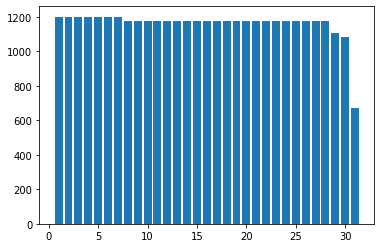

In [9]:
# checking what days we have in our data
counts = final["Day"].value_counts()
plt.bar(counts.index, counts.values)
plt.show()
# counig avaivle entries in the dataset , dosent not gives an corelation data

<AxesSubplot:xlabel='Day', ylabel='Value (kWh)'>

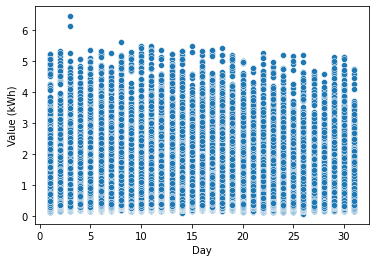

In [10]:
sns.scatterplot( final["Day"], final["Value (kWh)"] )

# use when values of X axis are a lot or or are in float 

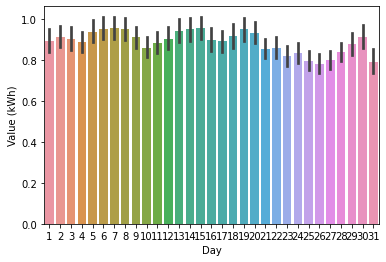

In [11]:
# Bar plot is a simple plot which we can use to plot categorical variable on the x-axis and numerical variable on y-axis and explore the relationship between both variables. 
sns.barplot(final["Day"], final["Value (kWh)"], )
plt.show()
# plt.title()

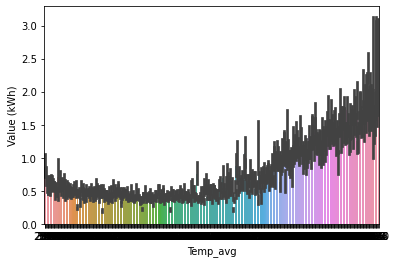

In [12]:
sns.barplot(final["Temp_avg"], final["Value (kWh)"], )
plt.show()
# title = temprature VS power consumption

In [13]:
fig = px.histogram(final, x='Temp_avg', y ='Value (kWh)', color='notes', marginal='box')
fig.show()

<AxesSubplot:xlabel='Temp_avg', ylabel='Value (kWh)'>

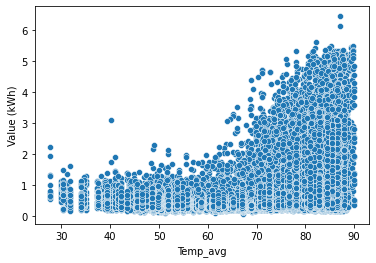

In [14]:
sns.scatterplot( final["Temp_avg"], final["Value (kWh)"])
# same tempratureVS consumption graph 
# scatter graph suits better

In [15]:
fig = px.histogram(final, x='Hum_avg', y ='Value (kWh)', color='notes', marginal='box')
fig.show()

<AxesSubplot:xlabel='Hum_avg', ylabel='Value (kWh)'>

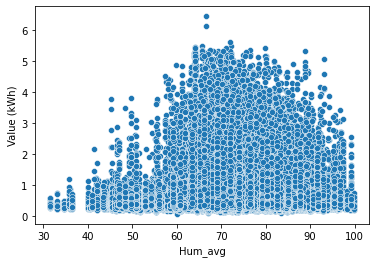

In [16]:
sns.scatterplot( final["Hum_avg"], final["Value (kWh)"])

In [17]:
fig = px.histogram(final, x='Dew_avg', y ='Value (kWh)', color='notes')#, marginal='box')
fig.show()

<AxesSubplot:xlabel='Dew_avg', ylabel='Value (kWh)'>

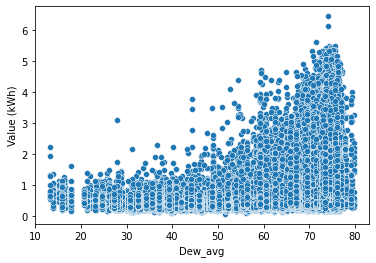

In [18]:
sns.scatterplot( final["Dew_avg"], final["Value (kWh)"])

In [19]:
fig = px.histogram(final, x='Wind_avg', y ='Value (kWh)', color='notes')#, marginal='box')
fig.show()

<AxesSubplot:xlabel='Wind_avg', ylabel='Value (kWh)'>

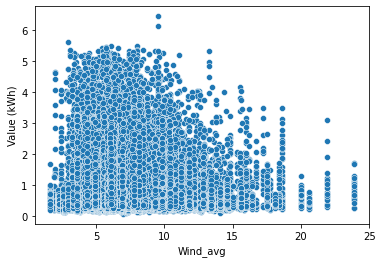

In [20]:
sns.scatterplot( final["Wind_avg"], final["Value (kWh)"])

In [21]:
fig = px.histogram(final, x='Press_avg', y ='Value (kWh)', color='notes')#, marginal='box')
fig.show()

**some corelations based on time features**

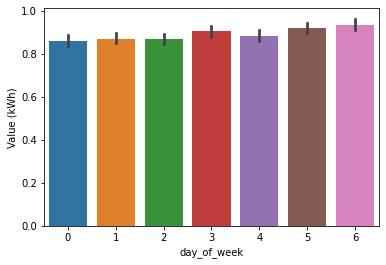

In [22]:
sns.barplot(final["day_of_week"], final["Value (kWh)"], )
plt.show()


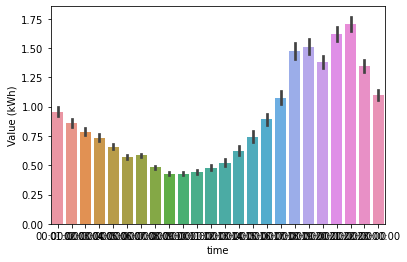

In [23]:
sns.barplot(final["time"], final["Value (kWh)"])#,ax = a1 )
plt.show()
# shows a strong corelation between power consumed and tie of the day

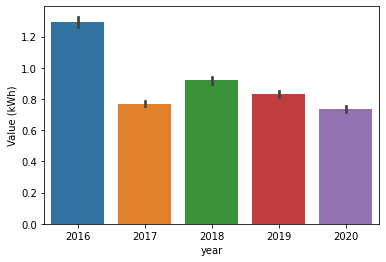

In [24]:
sns.barplot(final["year"], final["Value (kWh)"], )
plt.show()


([<matplotlib.patches.Wedge at 0x7f75cb783a10>,
 [Text(0.8745644642473387, 0.667185879553641, '2016'),
  Text(-0.4207101782940218, 1.0163675250025517, '2017'),
  Text(-1.0599627614699125, -0.2940730254495937, '2018'),
  Text(0.22037102384284274, -1.077699685371791, '2019'),
  Text(1.0413009760948169, -0.3545310665992215, '2020')],
 [Text(0.47703516231673015, 0.3639195706656223, '20.74%'),
  Text(-0.2294782790694664, 0.5543822863650281, '21.00%'),
  Text(-0.5781615062563159, -0.16040346842705108, '25.12%'),
  Text(0.12020237664155058, -0.5878361920209769, '22.69%'),
  Text(0.5679823505971728, -0.19338058178139353, '10.45%')])

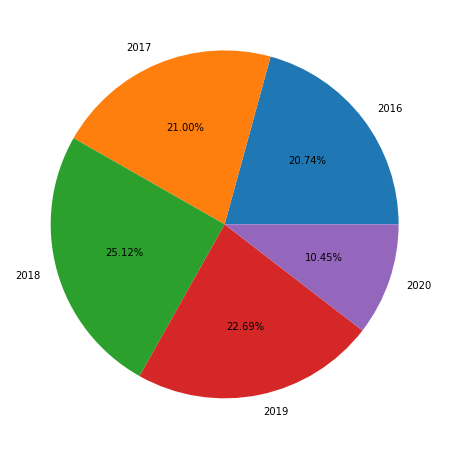

In [25]:
df2 = final.groupby('year')['Value (kWh)'].sum().reset_index()
plt.figure(figsize=(10,8))
plt.pie(df2['Value (kWh)'],labels= df2['year'],autopct='%1.2f%%', normalize=True)

([<matplotlib.patches.Wedge at 0x7f75d0018750>,
 [Text(0.8745644642473387, 0.667185879553641, '2016'),
  Text(-0.4207101782940218, 1.0163675250025517, '2017'),
  Text(-1.0599627614699125, -0.2940730254495937, '2018'),
  Text(0.22037102384284274, -1.077699685371791, '2019'),
  Text(1.0413009760948169, -0.3545310665992215, '2020')],
 [Text(0.47703516231673015, 0.3639195706656223, '20.74%'),
  Text(-0.2294782790694664, 0.5543822863650281, '21.00%'),
  Text(-0.5781615062563159, -0.16040346842705108, '25.12%'),
  Text(0.12020237664155058, -0.5878361920209769, '22.69%'),
  Text(0.5679823505971728, -0.19338058178139353, '10.45%')])

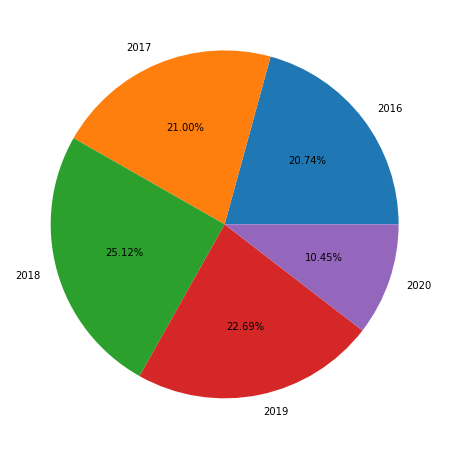

In [26]:
df2 = final.groupby('year')['Value (kWh)'].sum().reset_index()
plt.figure(figsize=(10,8))
plt.pie(df2['Value (kWh)'],labels= df2['year'],autopct='%1.2f%%', normalize=True)

([<matplotlib.patches.Wedge at 0x7f75d01e0a10>,
 [Text(-0.2616708688993113, 1.3243973559206013, 'weekday'),
  Text(-0.5732838001191908, 1.222229800209805, 'weekend'),
  Text(-0.7799529014957949, -1.1018953995040959, 'vacation'),
  Text(1.022626016262376, 0.8813262908045708, 'COVID_lockdown')],
 [Text(-0.16475573226993673, 0.8338798166907487, '6.21%'),
  Text(-0.36095646674171267, 0.7695520964283957, '1.54%'),
  Text(-0.4910814564973523, -0.6937859922803565, '64.89%'),
  Text(0.6438756398689033, 0.5549091460621371, '27.36%')])

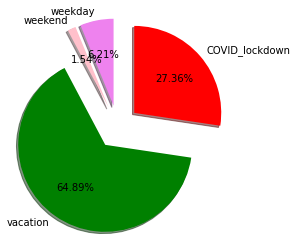

In [27]:
df4 = final.groupby('notes')['Value (kWh)'].sum().reset_index()
plt.pie(df4['Value (kWh)'],labels= ['weekday', 'weekend', 'vacation', 'COVID_lockdown'],
        normalize=True,autopct='%1.2f%%',startangle=90,explode=[0.25,0.25,0.25,0.25],shadow=True,colors=['violet','pink','green','red'])

# USING AUTOMATED VISULIZER visualizatons
> https://analyticsindiamag.com/tips-for-automating-eda-using-pandas-profiling-sweetviz-and-autoviz-in-python/

In [28]:
# !pip install autoviz #insatlling autoviz
# !pip install xlrd
# from autoviz.AutoViz_Class import AutoViz_Class
# autoviz = AutoViz_Class().AutoViz(final)


In [29]:
# from pandas_profiling import ProfileReport
# design_report = ProfileReport(final)
# design_report.to_file(output_file='report.html')

<AxesSubplot:xlabel='day_of_year', ylabel='Value (kWh)'>

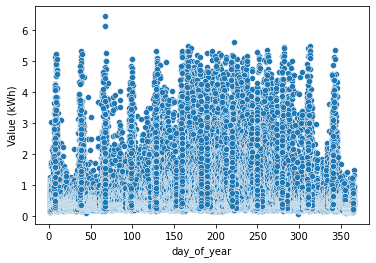

In [30]:
# scatterplot gives us an idea about the seasonality 
# there is this wave formate that the useage keeps surging after a specific duration and then drop afterthat
sns.scatterplot(x='day_of_year', y='Value (kWh)', data=final, palette='Blues')

# PLOTTING OF TIMESERIES FEATURES


In [31]:
encoder = OrdinalEncoder()
c = ['time']
final[c] = encoder.fit_transform(final[c])

<AxesSubplot:title={'center':'Seasonal Plot (Day/time)'}, xlabel='time', ylabel='Value (kWh)'>

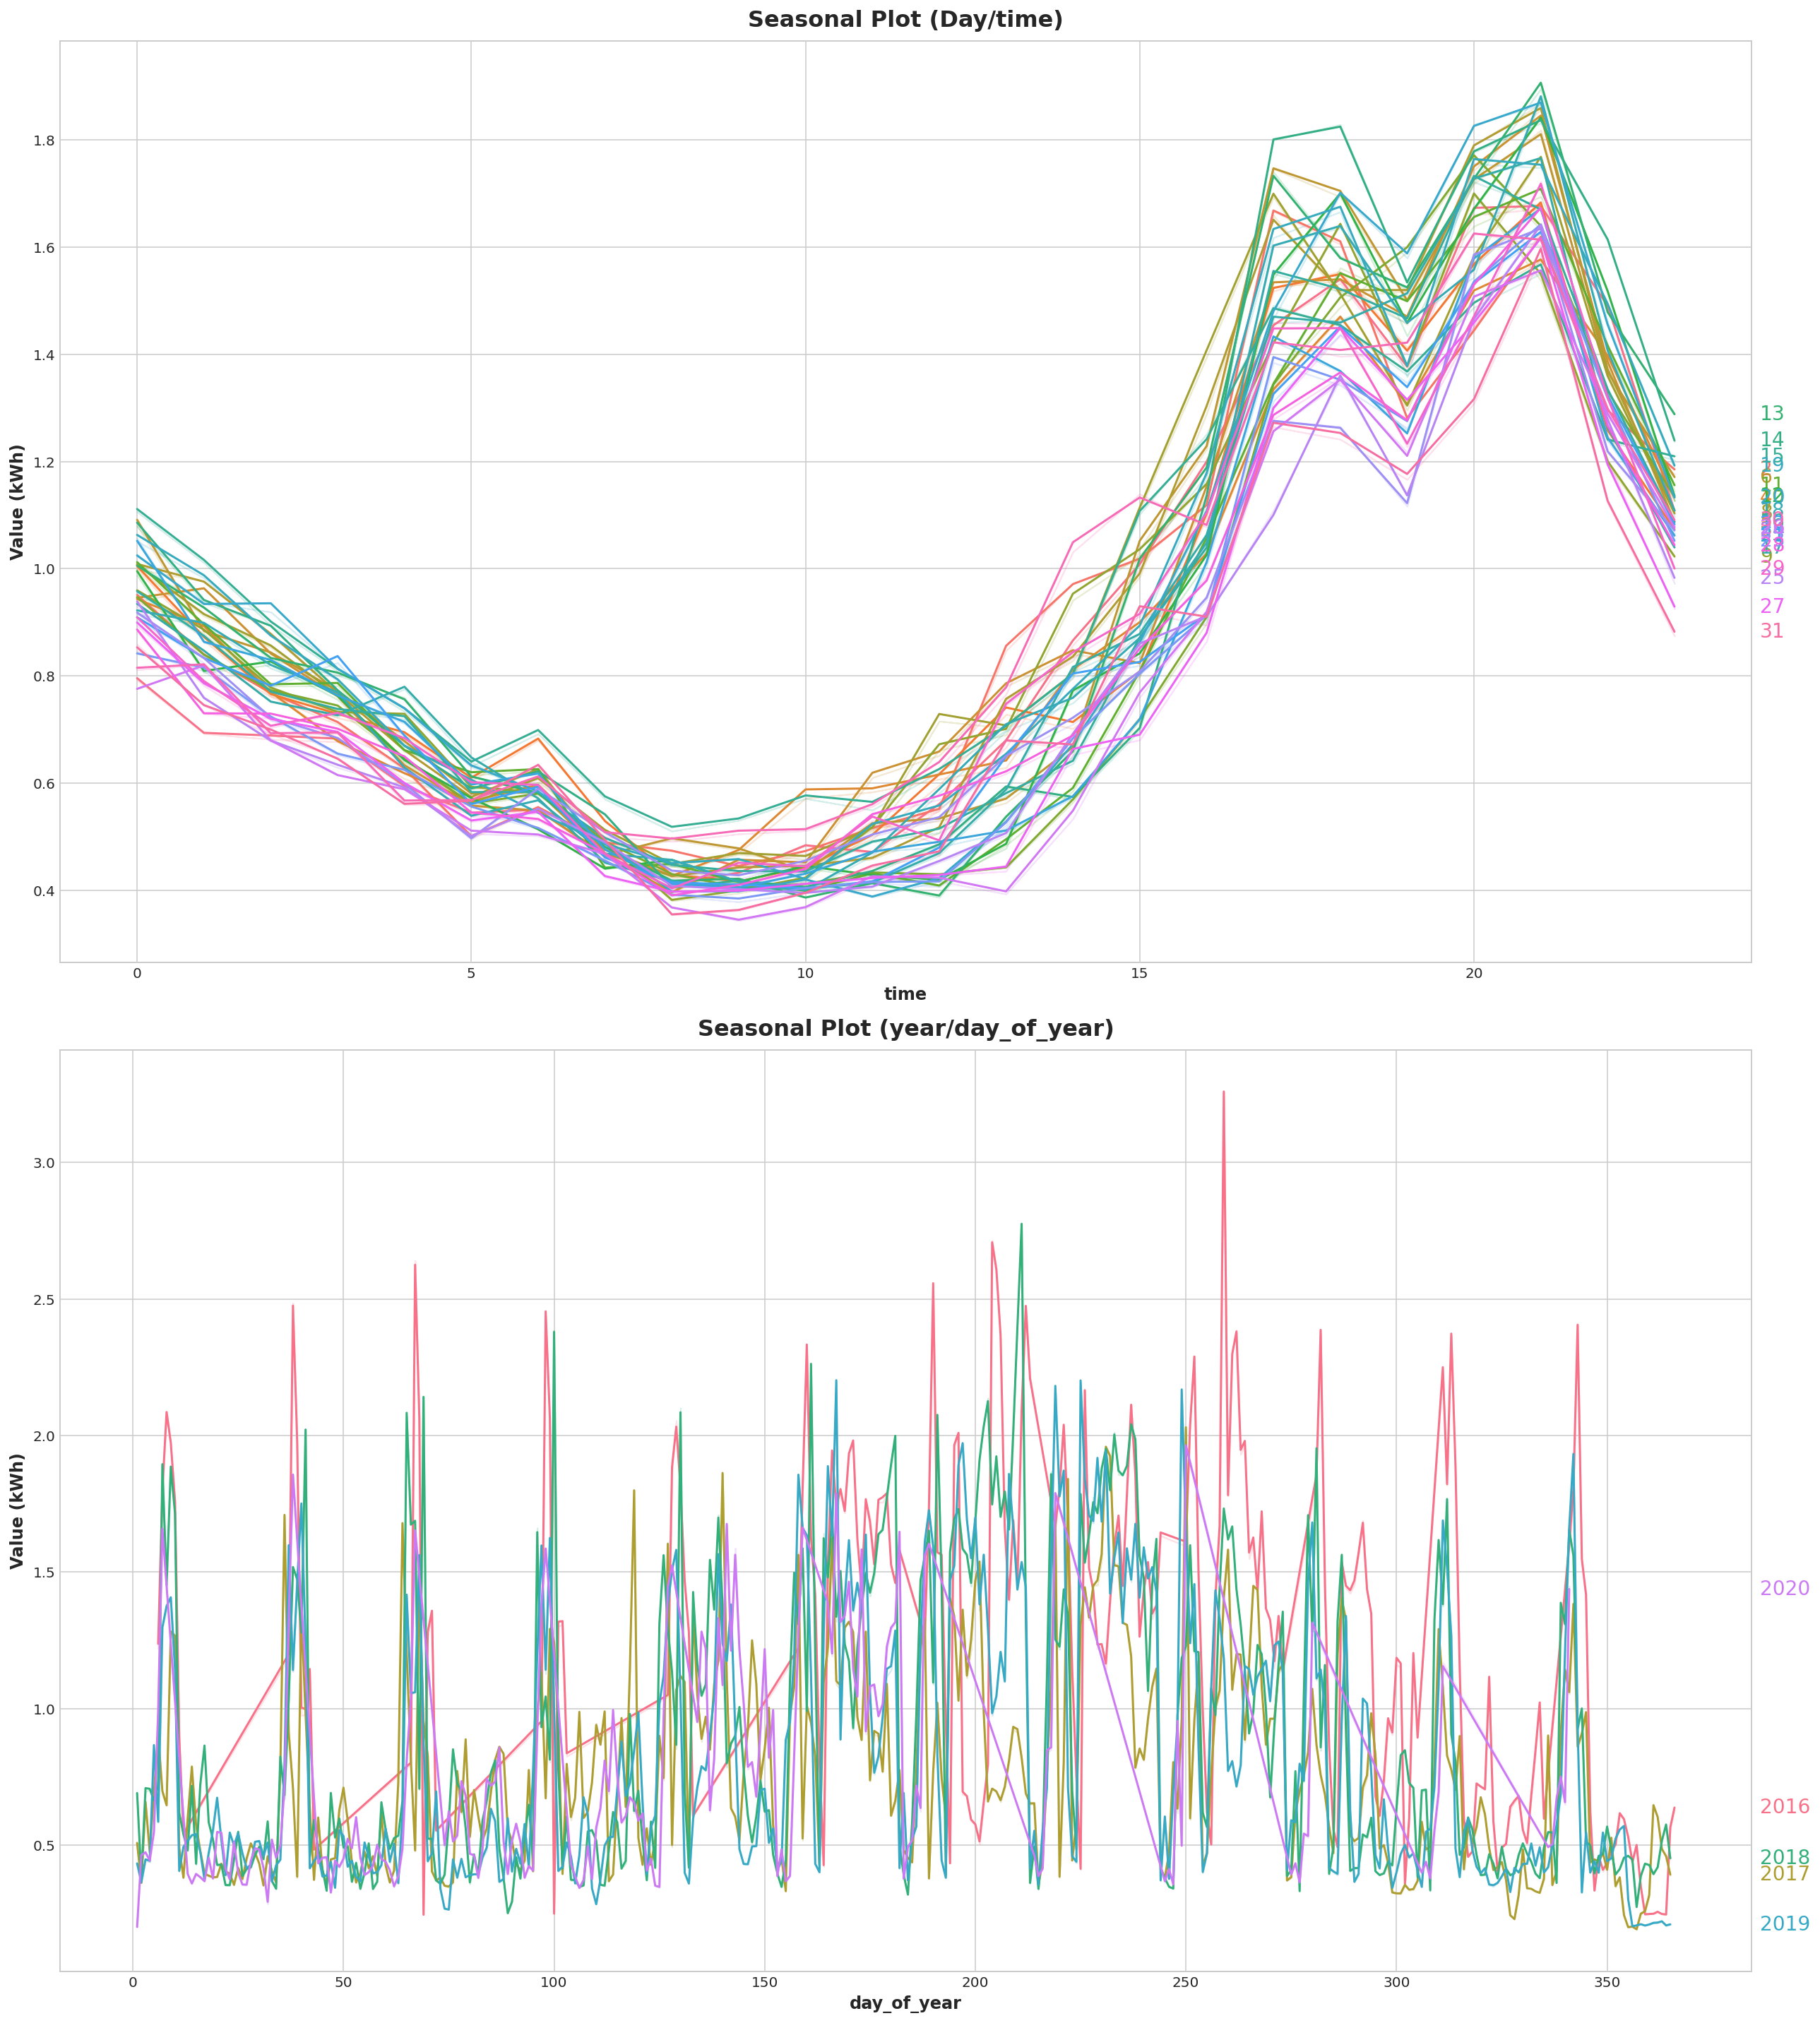

In [32]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(18, 20))

# plotting the seasonality graph
seasonal_plot(final, y="Value (kWh)", period="year", freq="day_of_year", ax=ax1)
seasonal_plot(final, y="Value (kWh)", period="Day", freq="time", ax=ax0)


**from the figure above no such weekly seasonality can be seen but there exist a monthly seasonality**

# doing regression without time series features

In [33]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35952 entries, 0 to 35951
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Value (kWh)     35952 non-null  float64       
 1   notes           35952 non-null  object        
 2   Date            35952 non-null  datetime64[ns]
 3   time            35952 non-null  float64       
 4   Day             35952 non-null  int64         
 5   Temp_max        35952 non-null  int64         
 6   Temp_avg        35952 non-null  float64       
 7   Temp_min        35952 non-null  int64         
 8   Dew_max         35952 non-null  int64         
 9   Dew_avg         35952 non-null  float64       
 10  Dew_min         35952 non-null  int64         
 11  Hum_max         35952 non-null  int64         
 12  Hum_avg         35952 non-null  float64       
 13  Hum_min         35952 non-null  int64         
 14  Wind_max        35952 non-null  int64         
 15  Wi

**the abouve data-set has 2 unacceptable values**

> **1st is datetime value**
/
> **2nd is object value**

In [34]:
# first removing object values using ordinal encoder
encoder = OrdinalEncoder()

# determining object columns for transformation
col = ['notes']
final[col] = encoder.fit_transform(final[col])

# checking for dtype values
final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35952 entries, 0 to 35951
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Value (kWh)     35952 non-null  float64       
 1   notes           35952 non-null  float64       
 2   Date            35952 non-null  datetime64[ns]
 3   time            35952 non-null  float64       
 4   Day             35952 non-null  int64         
 5   Temp_max        35952 non-null  int64         
 6   Temp_avg        35952 non-null  float64       
 7   Temp_min        35952 non-null  int64         
 8   Dew_max         35952 non-null  int64         
 9   Dew_avg         35952 non-null  float64       
 10  Dew_min         35952 non-null  int64         
 11  Hum_max         35952 non-null  int64         
 12  Hum_avg         35952 non-null  float64       
 13  Hum_min         35952 non-null  int64         
 14  Wind_max        35952 non-null  int64         
 15  Wi

In [35]:
# filling missing values using"fillna"
# preparing dataset to bbe model-fitting ready
final.fillna(final.median().round(1), inplace=True)

In [36]:
X= final.drop([ 'is_month_start', 'month','day_of_year',
              'week_of_year','year', 'quarter','is_month_start','Date'] , axis =1)
y =final['Value (kWh)']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.15, shuffle = True,   random_state = 1)
print(X_train.shape)
print(X_test.shape)

(30559, 22)
(5393, 22)


In [38]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()
rob_scaler.fit(X_train)
X_train = rob_scaler.transform(X_train)
X_test = rob_scaler.transform(X_test)

In [39]:
k_fold = KFold(n_splits = 10, random_state = 11, shuffle = True)
def cv_rmse(model, X = X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

def rmsle(y, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y, y_pred, squared = False))
    return rmsle

In [40]:
# fitting RANDOM FOREST MODEL for prediction
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf.fit(X_train,y_train)
predict = rf.predict(X_test)
rmsle = rmsle(y_test,predict)
mse = mean_squared_error(y_test,predict)
print("rsmle is :" ,rmsle)
print( "mse is :" , mse)

rsmle is : 0.012407236771570152
mse is : 7.105177730333548e-07


# doing regression again but this time more emphasisied on tim series features

<AxesSubplot:>

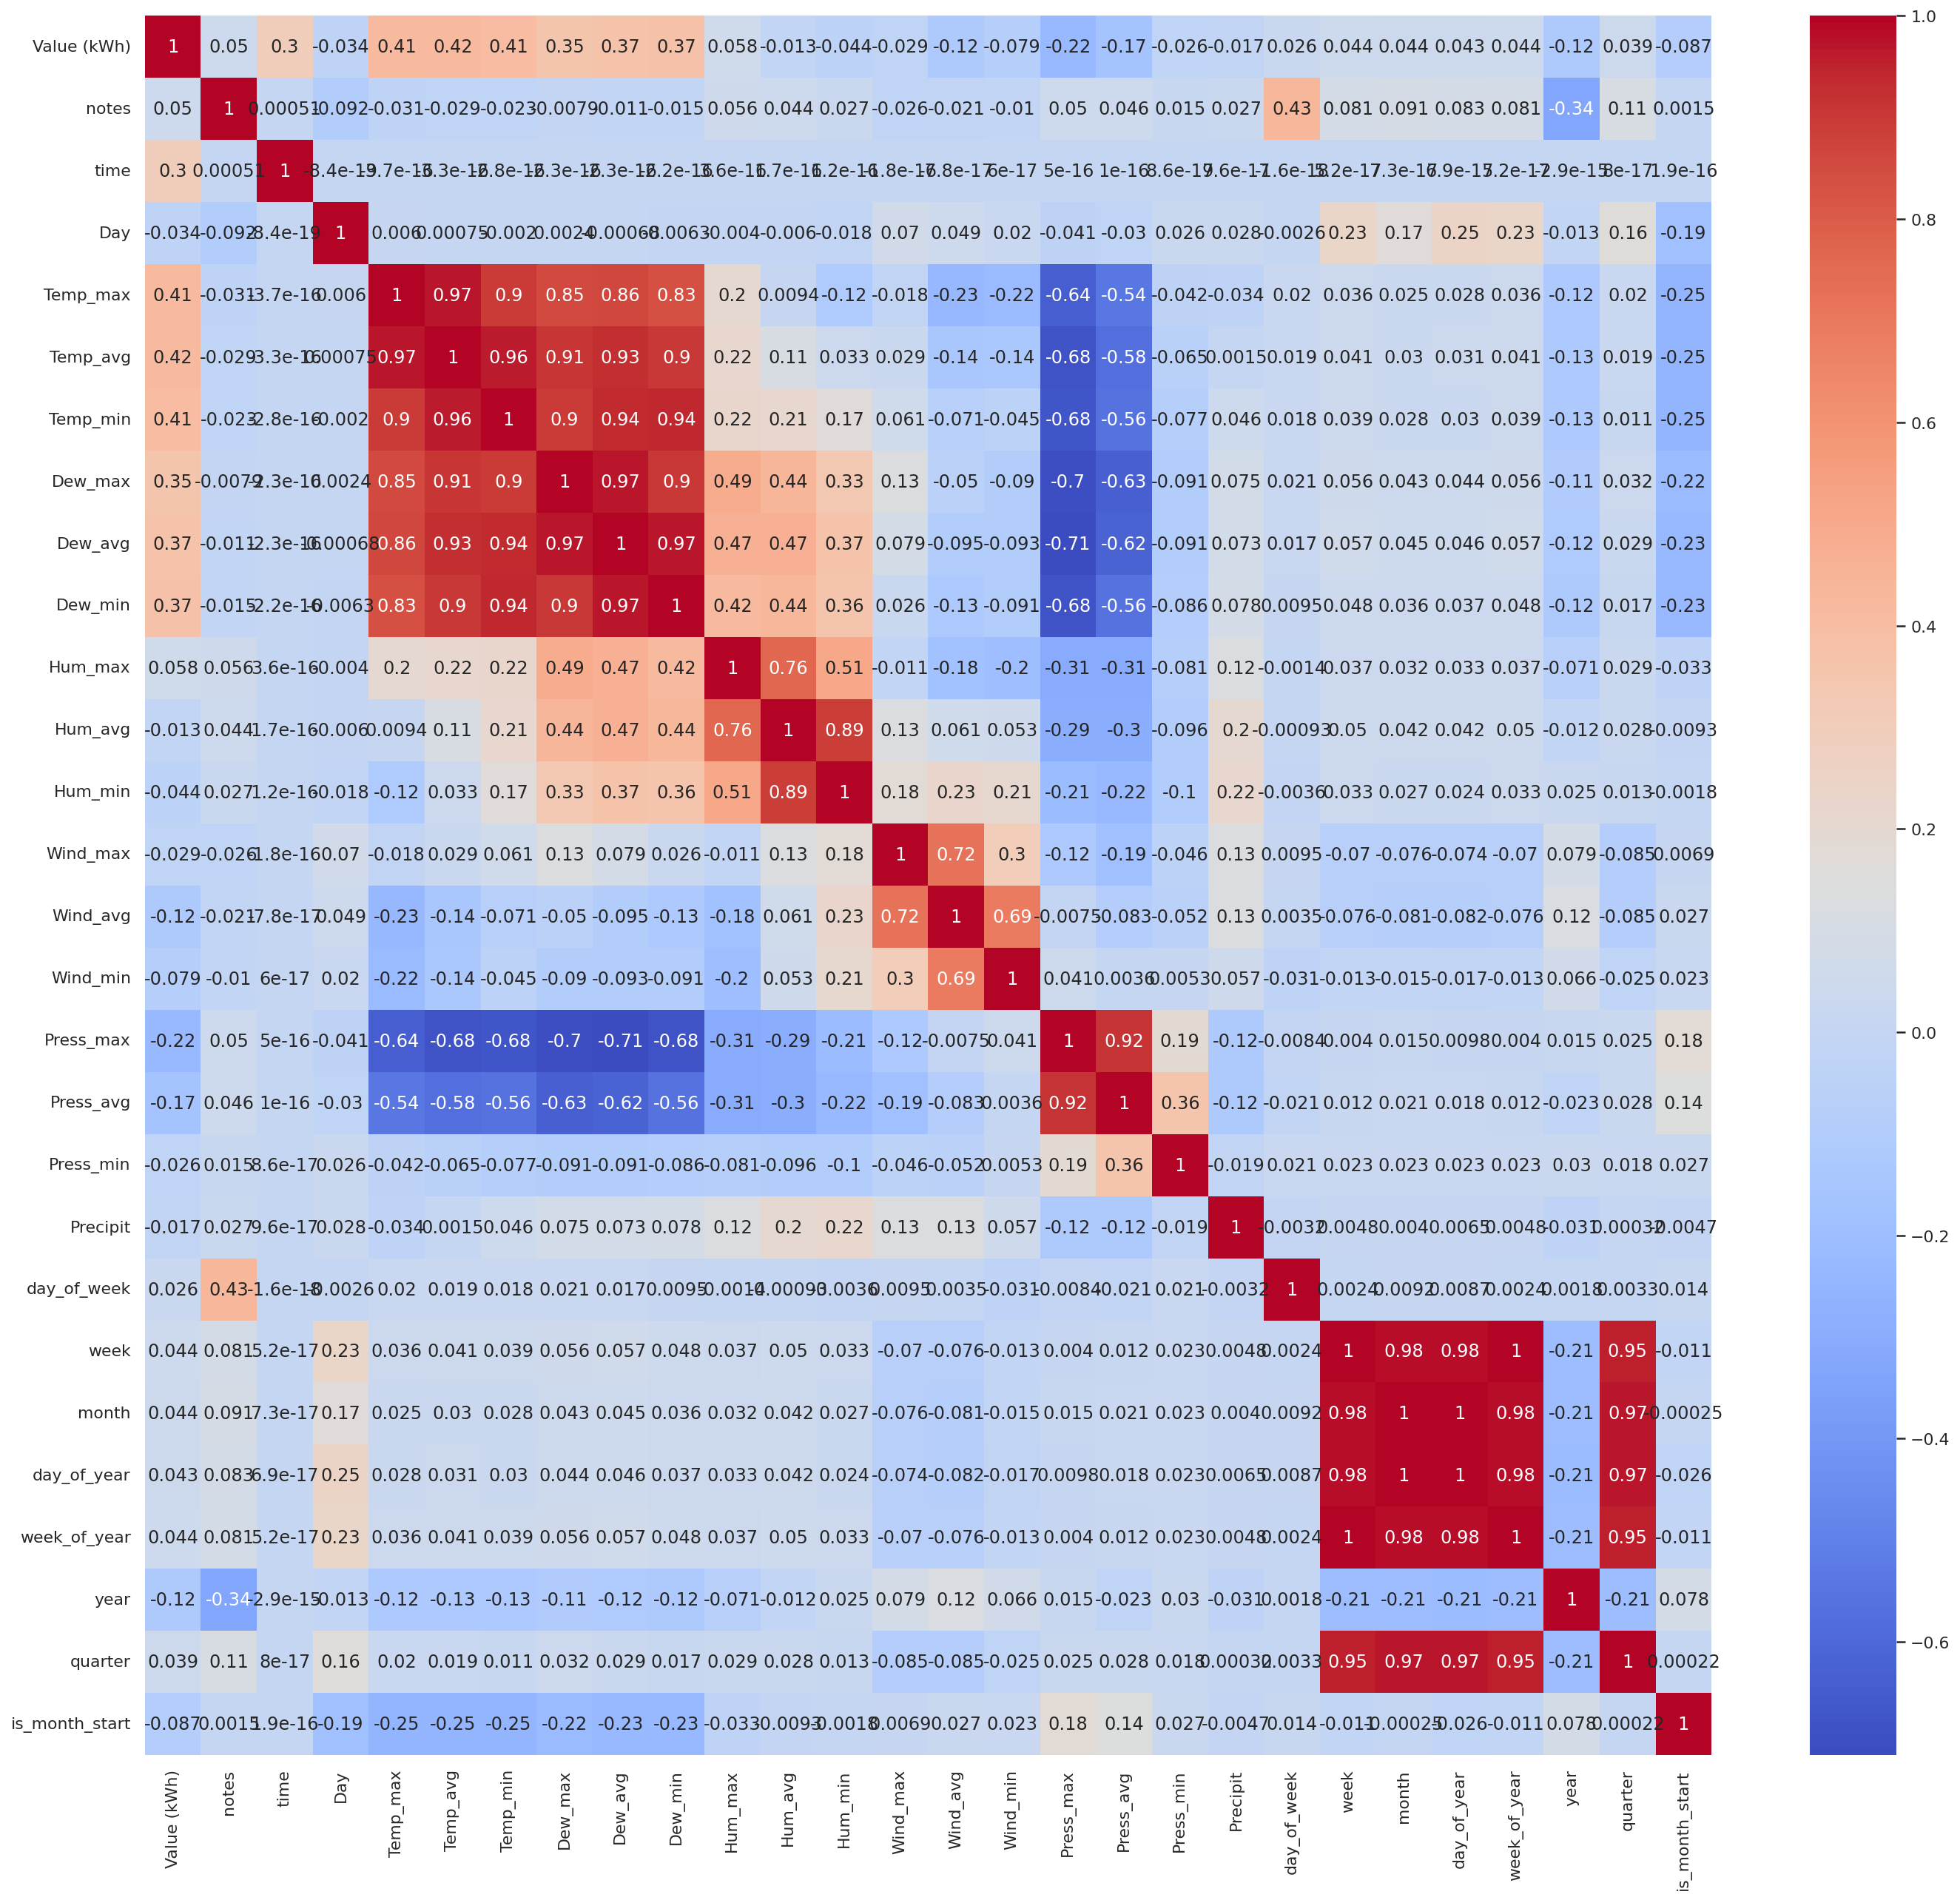

In [41]:
# correlation in heatmap form
final.corr()
sns.set(rc = {'figure.figsize':(20,18)})
sns.heatmap(final.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')


**dropping features with comparitvely less corellation**

In [42]:
# encoder = OrdinalEncoder()
# col = ['notes' , 'time']
# final[col] = encoder.fit_transform(final[col])

In [43]:
X2= final.drop(['Value (kWh)','Temp_max', 'Temp_min', 'Dew_max' , 'Dew_min', 'Hum_avg' ,'Hum_min' , 
               'Wind_max' , 'Wind_min' ,'Press_min' , 'Press_avg', 'Date'] , axis =1)
y2= y.copy()

X2['last_day_usage'] = final['Value (kWh)'].shift(1) 
X2['last_day_diff'] = X2['last_day_usage'].diff() 

# filling missing values created by LAG  and  DIFFERENCE features
X2.fillna(X2.median().round(1), inplace=True)

# sice we added lag feature taht caused missing vales so we have to drop missing one
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,
                                                    test_size = 0.10,
                                                    shuffle = True,
                                                    random_state = 1)

In [44]:
# cheching score
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf2.fit(X2_train,y2_train)
predict = rf2.predict(X2_test)
mse2 = mean_squared_error(y2_test,predict)
print(mse2)

0.1716289236970963


<AxesSubplot:xlabel='Day', ylabel='Value (kWh)'>

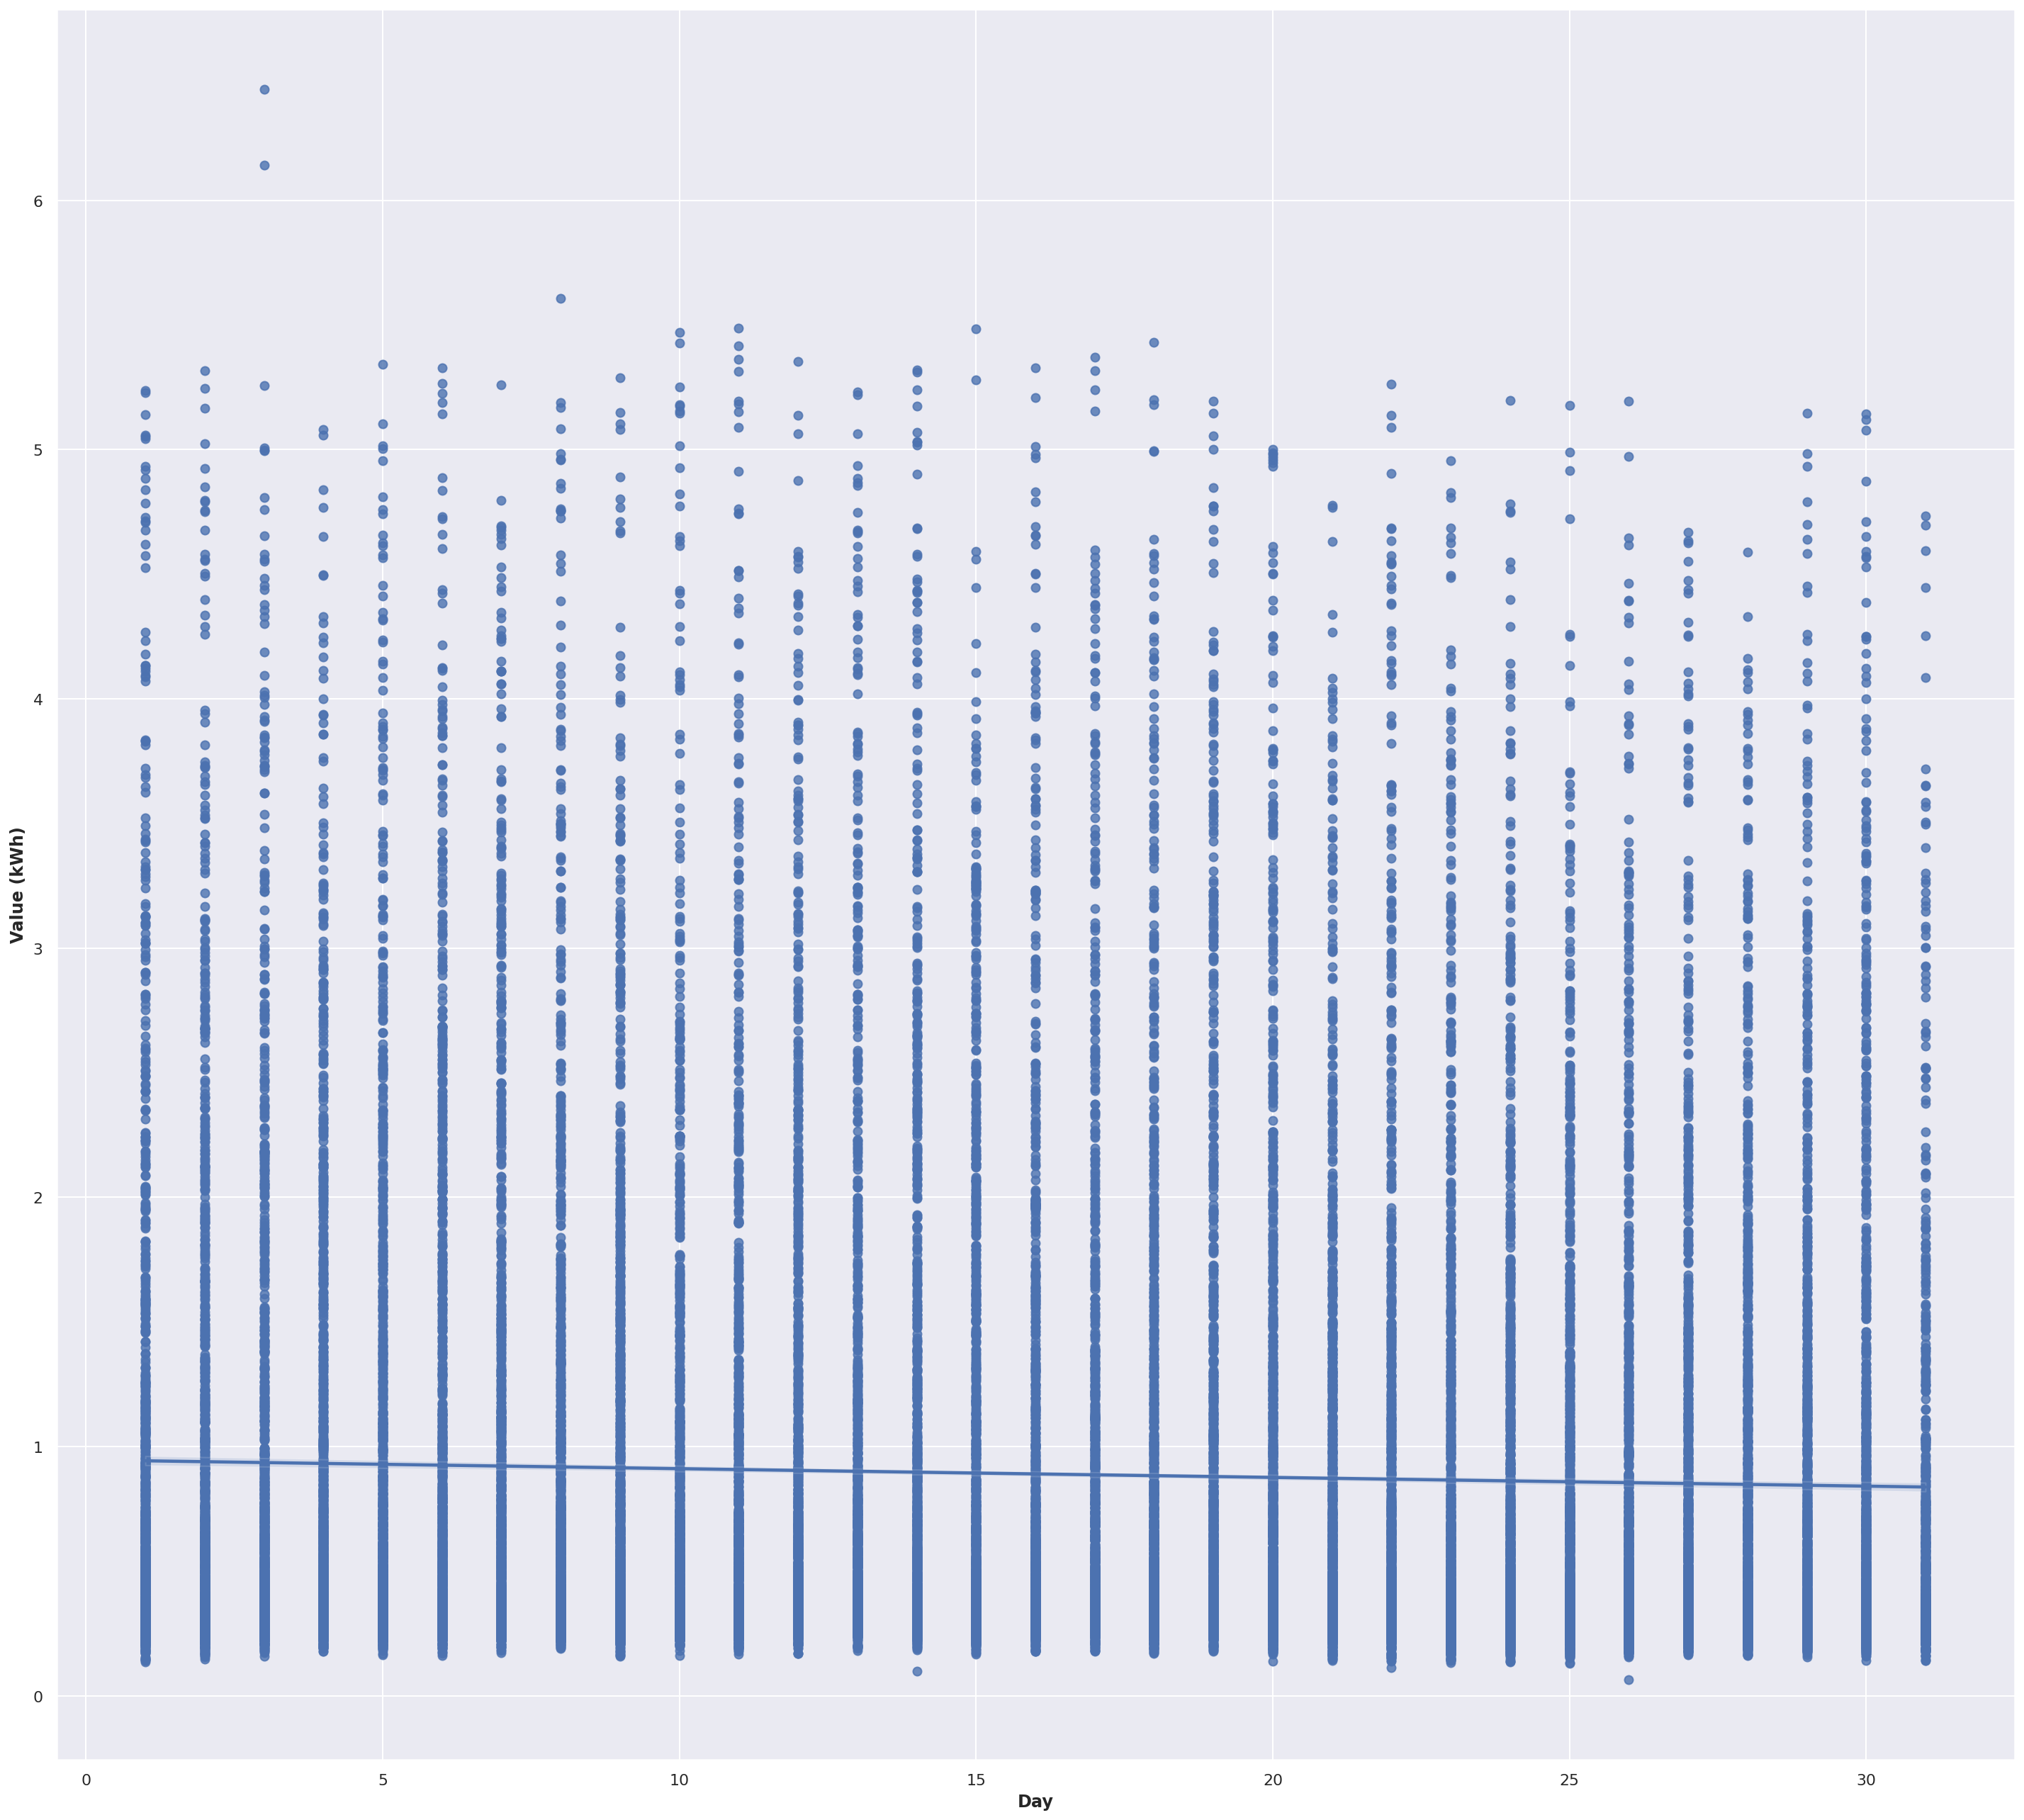

In [45]:
sns.regplot(data= final, y=final['Value (kWh)'], x= X2['Day'])

# using stacked model
> best ml regression try

In [46]:
# xgb = XGBRegressor(n_estimators = 1000, random_state = 1)
# lgbm = LGBMRegressor(n_estimators = 1000, random_state = 1)
# gbr = GradientBoostingRegressor(n_estimators = 1000, random_state = 11)
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
# svr = SVR(C = 20)
# lasso = LassoCV(alphas = [1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4,
#                                                         5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1,
#                                                         0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30,
#                                                         45, 50, 70, 90], n_jobs = -1, cv = k_fold)

# stacked = StackingCVRegressor(regressors = (xgb, lgbm, svr, lasso, gbr, rf),
#                               meta_regressor = xgb, use_features_in_secondary = True)

# #fit the stacked model
# stacked_model = stacked.fit(np.array(X_train), np.array(y_train))

In [47]:
# #RMSLE score of the stacked model on full TRAIN data

# stacked_score_train = rmsle(y_train, stacked_model.predict(X_train))
# print("RMSLE score of stacked models on full train data:", stacked_score_train)
# # RMSLE score of stacked models on full train data: 0.05532705864942081
# #RMSLE score of the stacked model on full TEST data

# stacked_score_test = rmsle(y_test, stacked_model.predict(X_test))
# print("RMSLE score of stacked models on full test data:", stacked_score_test)


In [48]:
# y_pred = np.expm1(stacked_model.predict(X_test))
# y_pred[0:5]

In [49]:
# print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print('R-squared: {}'.format(metrics.r2_score(y_test, y_pred)))

# Make predictionb using deep neural network 

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = [X2_train.shape[1]]
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(20 ,activation= 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(10 )
])    

    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    X2_train, y2_train,
#     validation_data=(X2_test, y2_test),
    validation_split= 0.2,
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)

2022-09-19 04:22:19.682177: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-19 04:22:19.902119: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
51/51 [==============================] - 2s 9ms/step - loss: 1.6537 - mean_squared_error: 1.6537 - val_loss: 4154.8457 - val_mean_squared_error: 4154.8457
Epoch 2/50
51/51 [==============================] - 0s 4ms/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 675.9385 - val_mean_squared_error: 675.9385
Epoch 3/50
51/51 [==============================] - 0s 4ms/step - loss: 0.6308 - mean_squared_error: 0.6308 - val_loss: 138.8306 - val_mean_squared_error: 138.8306
Epoch 4/50
51/51 [==============================] - 0s 5ms/step - loss: 0.4625 - mean_squared_error: 0.4625 - val_loss: 31.7544 - val_mean_squared_error: 31.7544
Epoch 5/50
51/51 [==============================] - 0s 5ms/step - loss: 0.3897 - mean_squared_error: 0.3897 - val_loss: 8.4164 - val_mean_squared_error: 8.4164
Epoch 6/50
51/51 [==============================] - 0s 4ms/step - loss: 0.3565 - mean_squared_error: 0.3565 - val_loss: 2.2613 - val_mean_squared_error: 2.2613
Epoch 7/50
51/51 [======

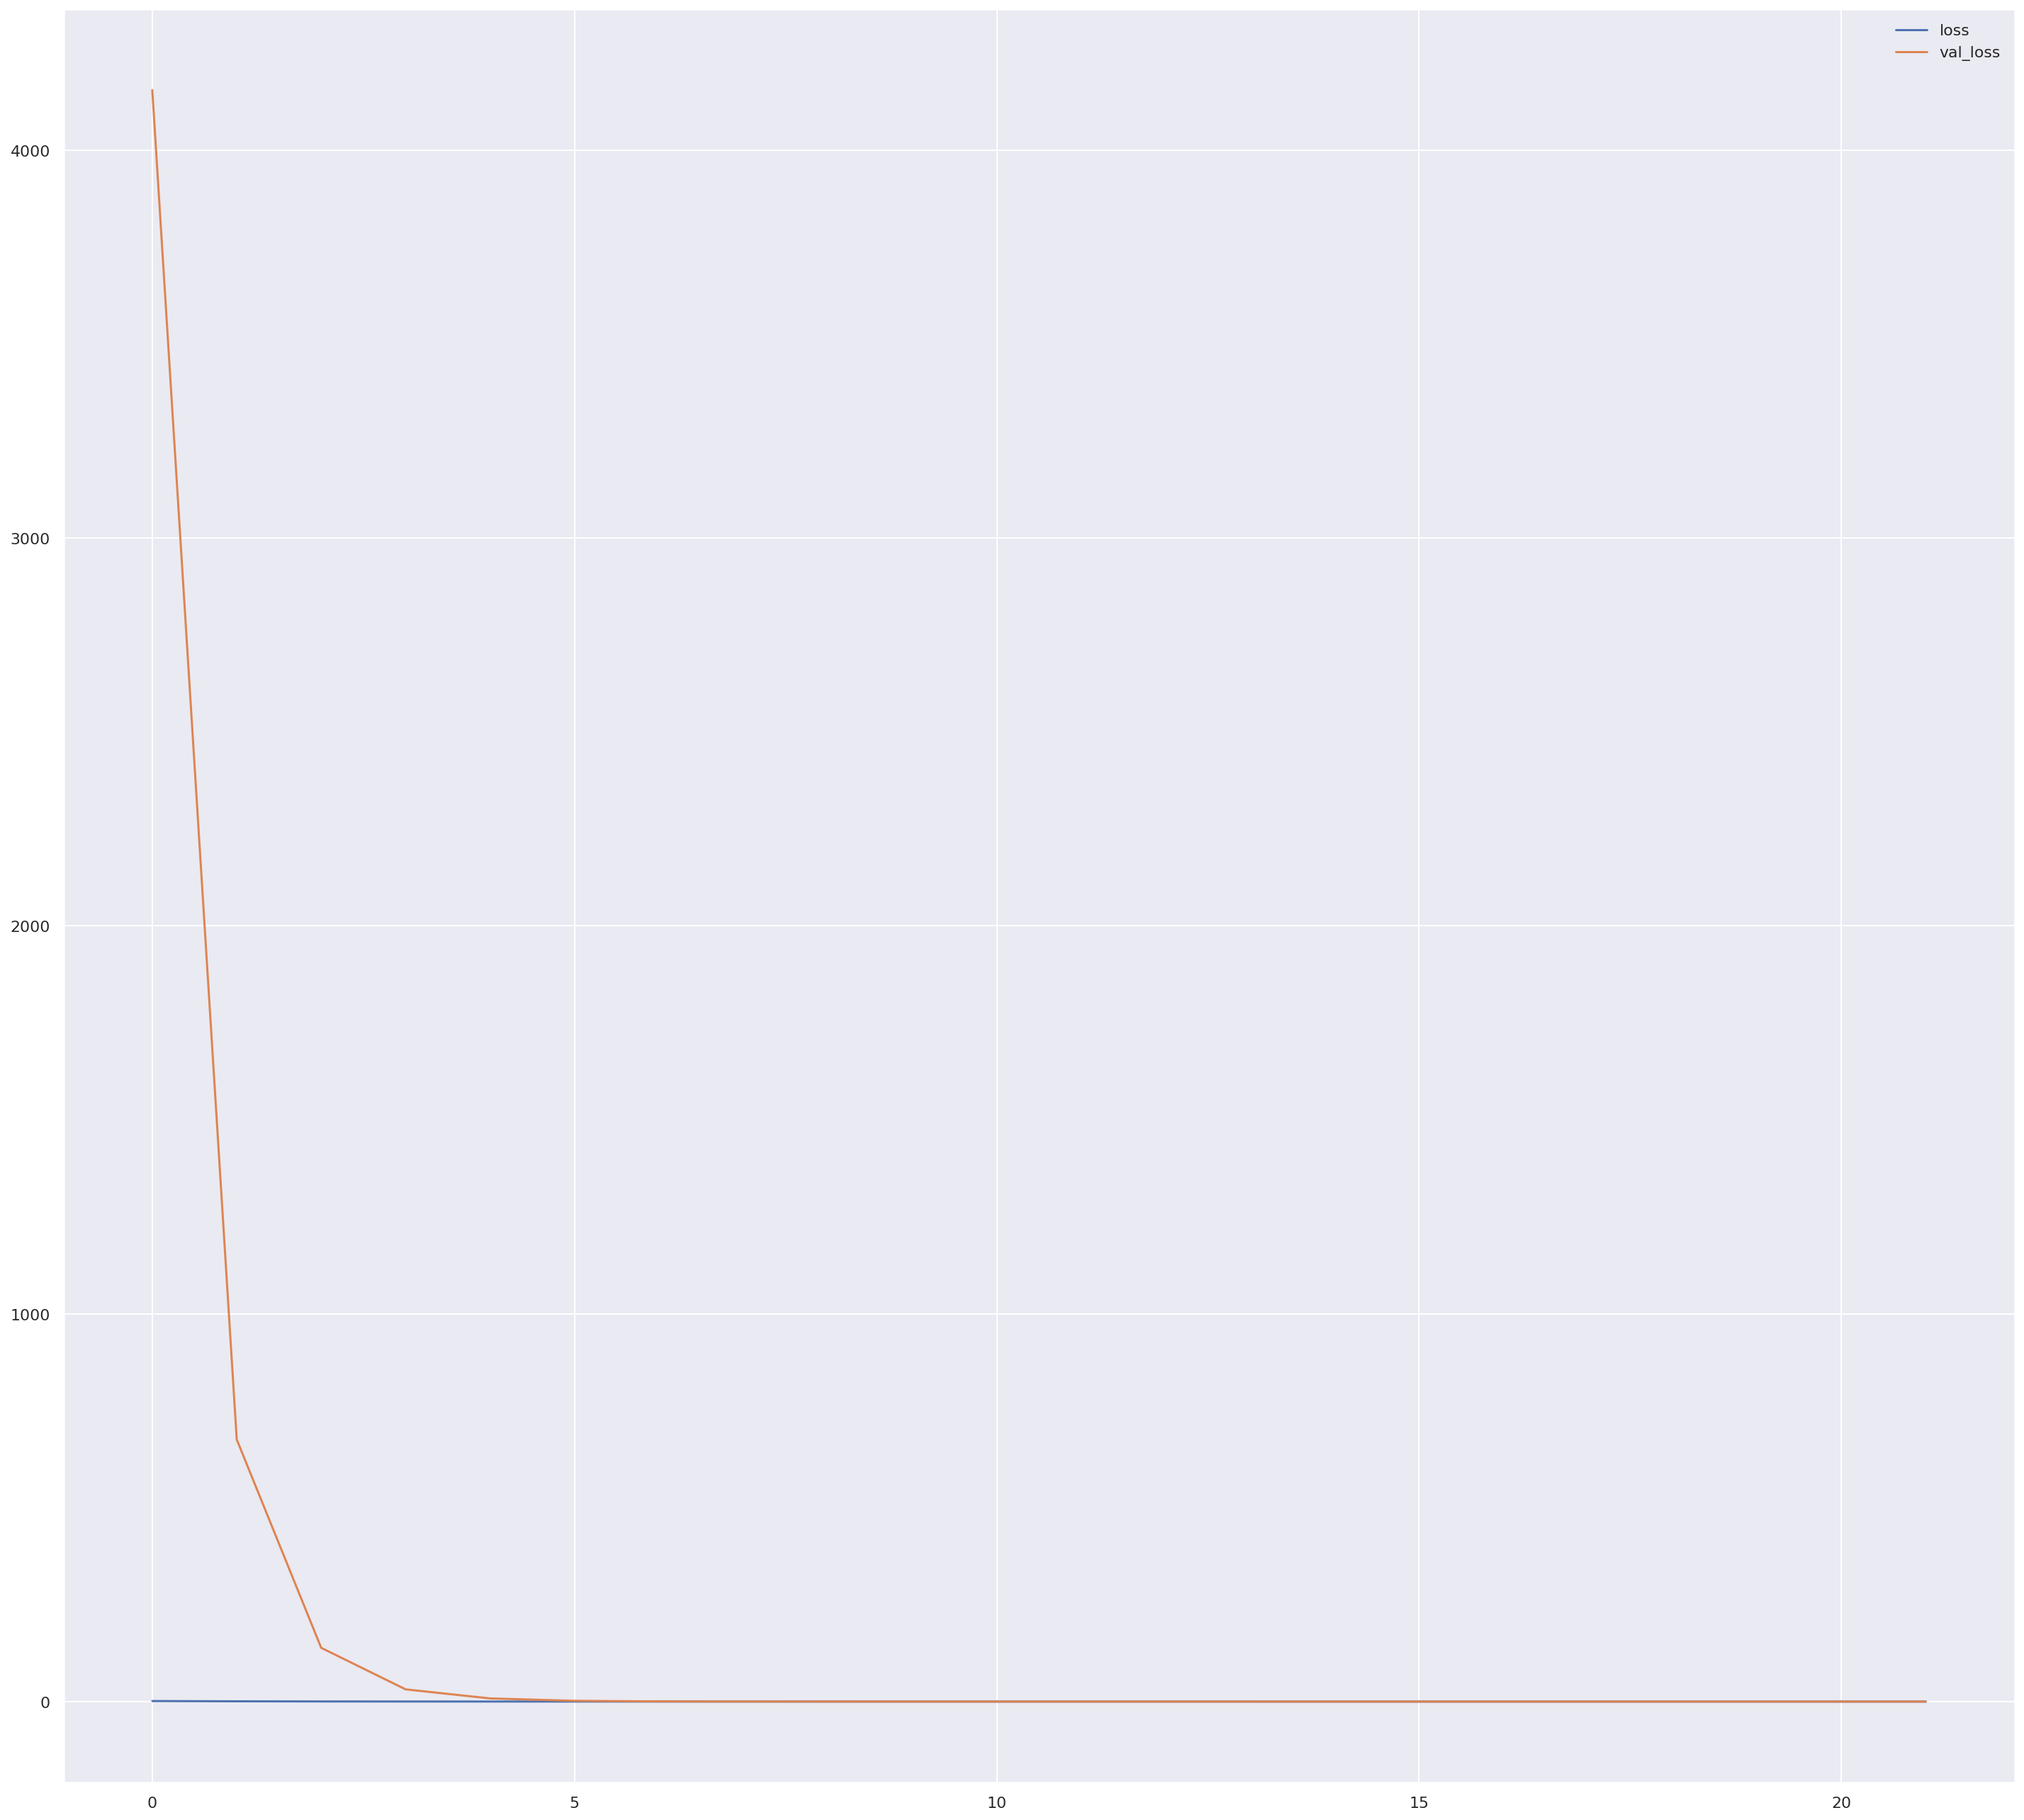

In [51]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [52]:
mse, mae = model.evaluate(X2_test , y2_test)
print( "mean square error is :" , mse)
print( "mean abosulte error is :" , mae)


113/113 [==============================] - 0s 1ms/step - loss: 0.2308 - mean_squared_error: 0.2308
mean square error is : 0.23080405592918396
mean abosulte error is : 0.23080405592918396


the mse went from 0.12068460639925611 using normal regression tooo 0.113326600829132 to finally using neural netwroks